In [1]:
import matplotlib.pyplot as plt
import torch
from data import load_dataset_and_make_dataloaders
import utils
from model import Model1, Model2, Model3
from fid import calculate_fid

gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")

In [2]:
dl, info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data 
    batch_size=5,
    num_workers=0,   # you can use more workers if you see the GPU is waiting for the batches
    pin_memory=gpu,  # use pin memory if you're planning to move the data to GPU
)

print(info)

for y, label in dl.train:
    imgs = y
    print(y.shape)
    print(label.shape)
    break

DataInfo(image_channels=1, image_size=32, num_classes=10, sigma_data=tensor(0.6641))
torch.Size([5, 1, 32, 32])
torch.Size([5])


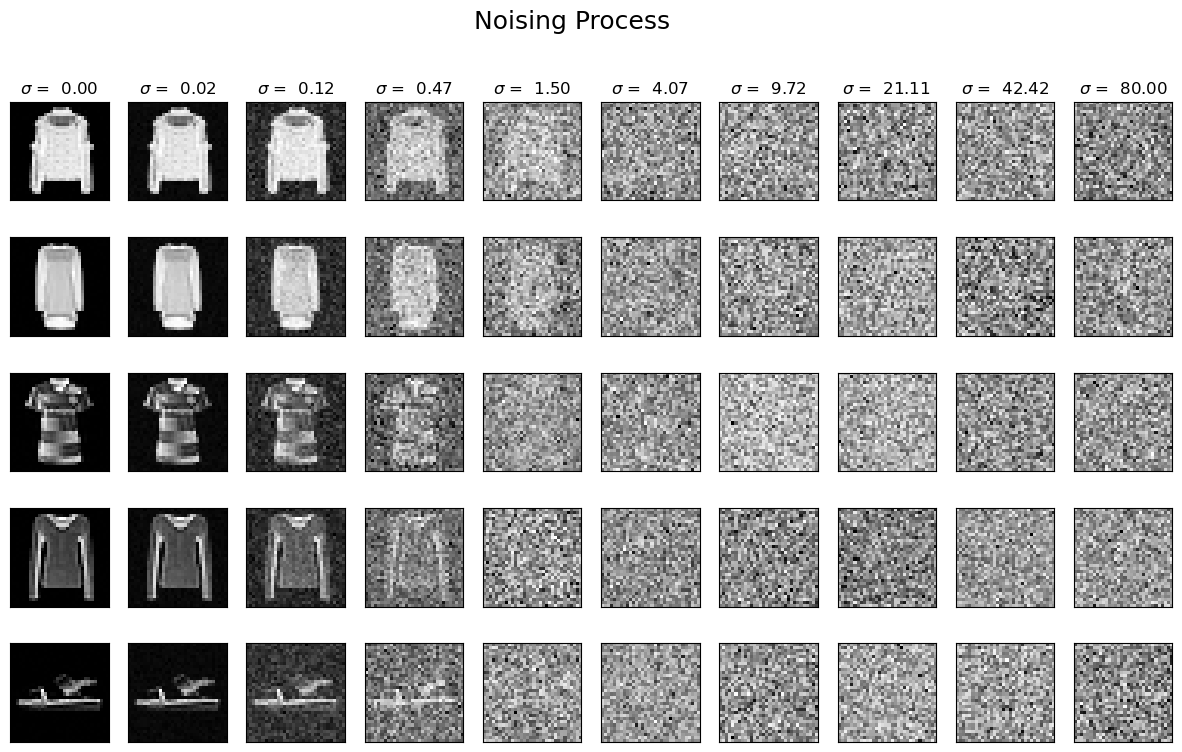

In [3]:
sigmas = utils.build_sigma_schedule(10)
noisy_imgs = utils.noising_process(imgs, sigmas)
utils.plot_imgs(noisy_imgs, sigmas, plot_name="noising_process", plot_title="Noising Process")

In [3]:
sigma_data = info.sigma_data.to(device)

def c_in(sigma):
    return 1. / torch.sqrt(sigma**2 + sigma_data**2)

def c_out(sigma):
    return sigma * sigma_data / torch.sqrt(sigma**2 + sigma_data**2)

def c_skip(sigma):
    return sigma_data**2 / (sigma**2 + sigma_data**2)

def c_noise(sigma):
    return torch.log(sigma) / 4.

def N(y, sigma): 
    return y + sigma * torch.randn(*y.shape, device=device)

In [12]:
model = Model1(image_channels=1, nb_channels=64, num_blocks=3, cond_channels=64).to(device)
F = model.forward

D = utils.denoiser(F, c_in, c_out, c_skip, c_noise)

# def D(x, sigma):
#     return c_skip(sigma[:,None,None,None]) * x + c_out(sigma[:,None,None,None]) * F(c_in(sigma[:,None,None,None]) * x, c_noise(sigma))

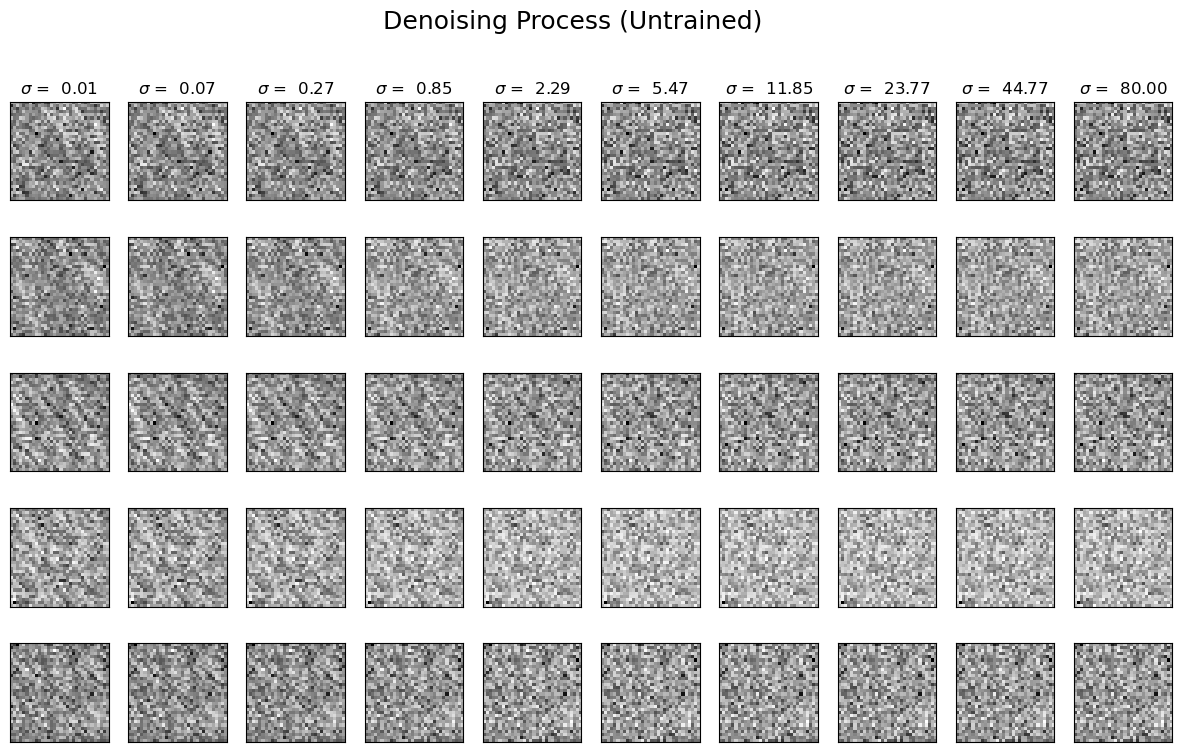

In [5]:
sigmas = utils.build_sigma_schedule(50).to(device)
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_untrained", plot_title="Denoising Process (Untrained)")

In [7]:
model = Model1(image_channels=1, nb_channels=32, num_blocks=3, cond_channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=5, lr=1e-2, batch_size=32)

torch.save(model.state_dict(), f"models/model1_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 5/5 [03:37<00:00, 43.59s/it]


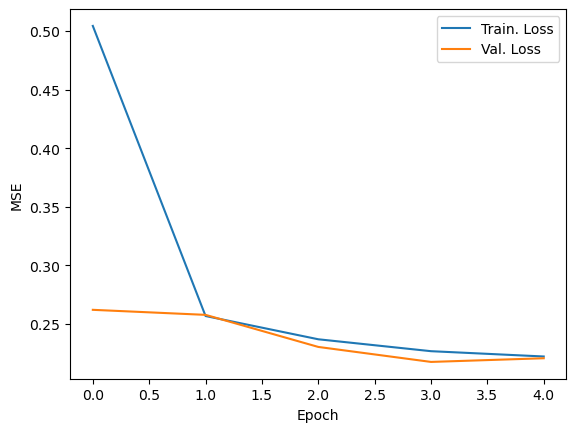

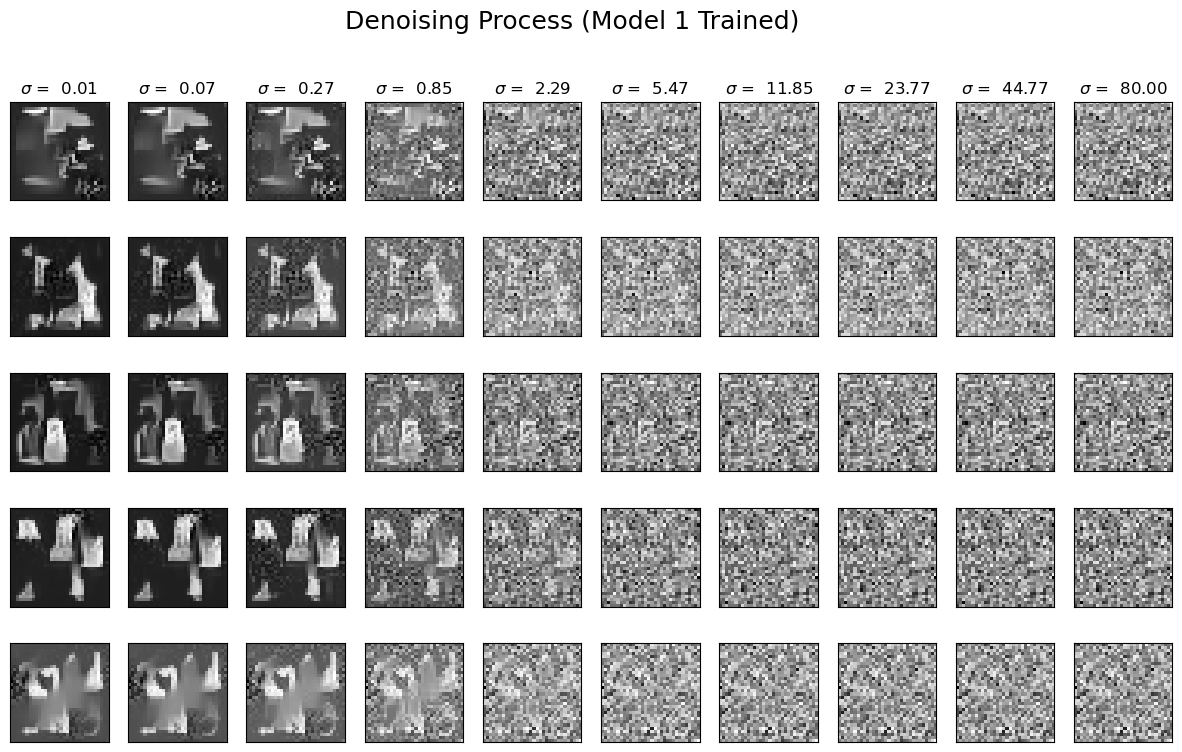

In [8]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

sigmas = utils.build_sigma_schedule(50).to(device)
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model1", plot_title="Denoising Process (Model 1 Trained)")

In [9]:
model = Model2(image_channels=1, nb_channels=32, num_blocks=3, cond_channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=5, lr=1e-2, batch_size=32)

torch.save(model.state_dict(), f"models/model2_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 5/5 [03:40<00:00, 44.04s/it]


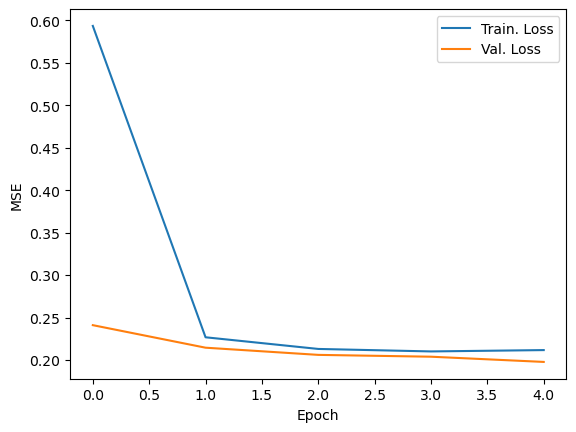

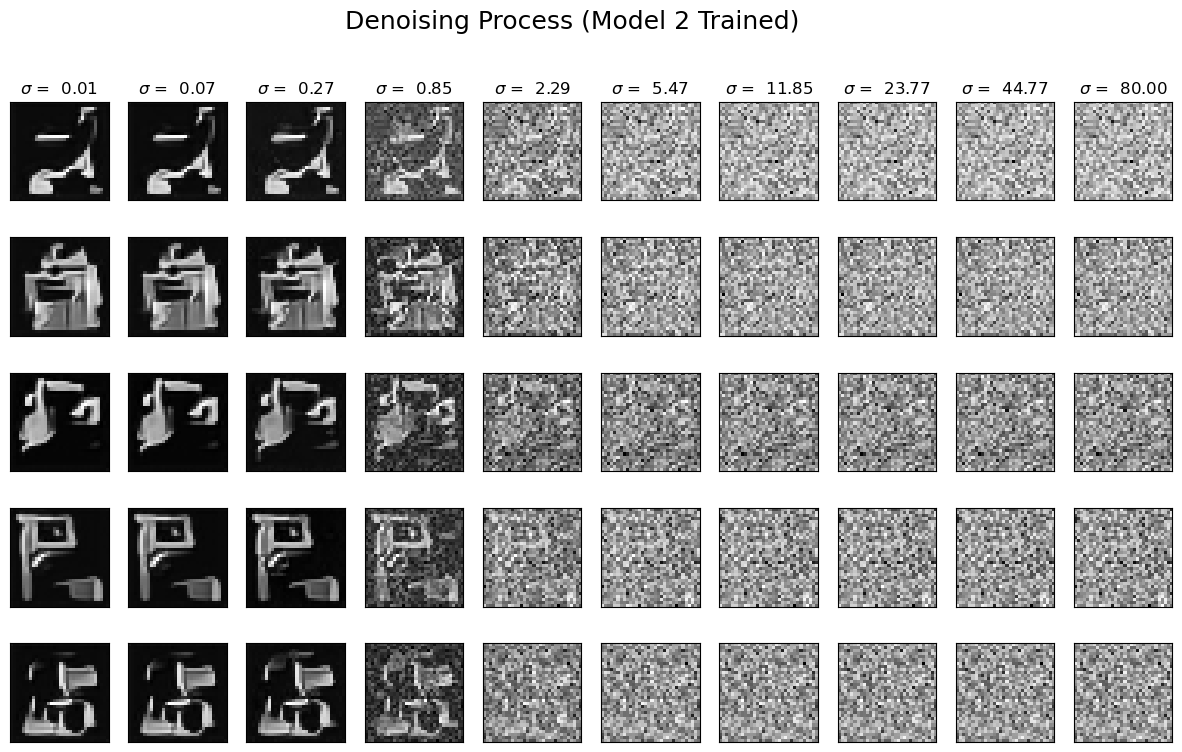

In [10]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

sigmas = utils.build_sigma_schedule(50).to(device)
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model2", plot_title="Denoising Process (Model 2 Trained)")

# Model 3 - Conditional connected to Residual blocks' BatchNorm affine parameters

In [51]:
model = Model3(image_channels=1, nb_channels=32, num_blocks=7, cond_channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=25, lr=1e-3, batch_size=32)

torch.save(model.state_dict(), f"models/model3_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 25/25 [37:44<00:00, 90.59s/it]


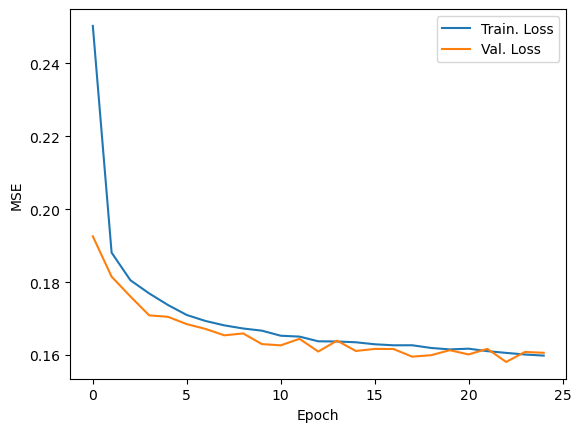

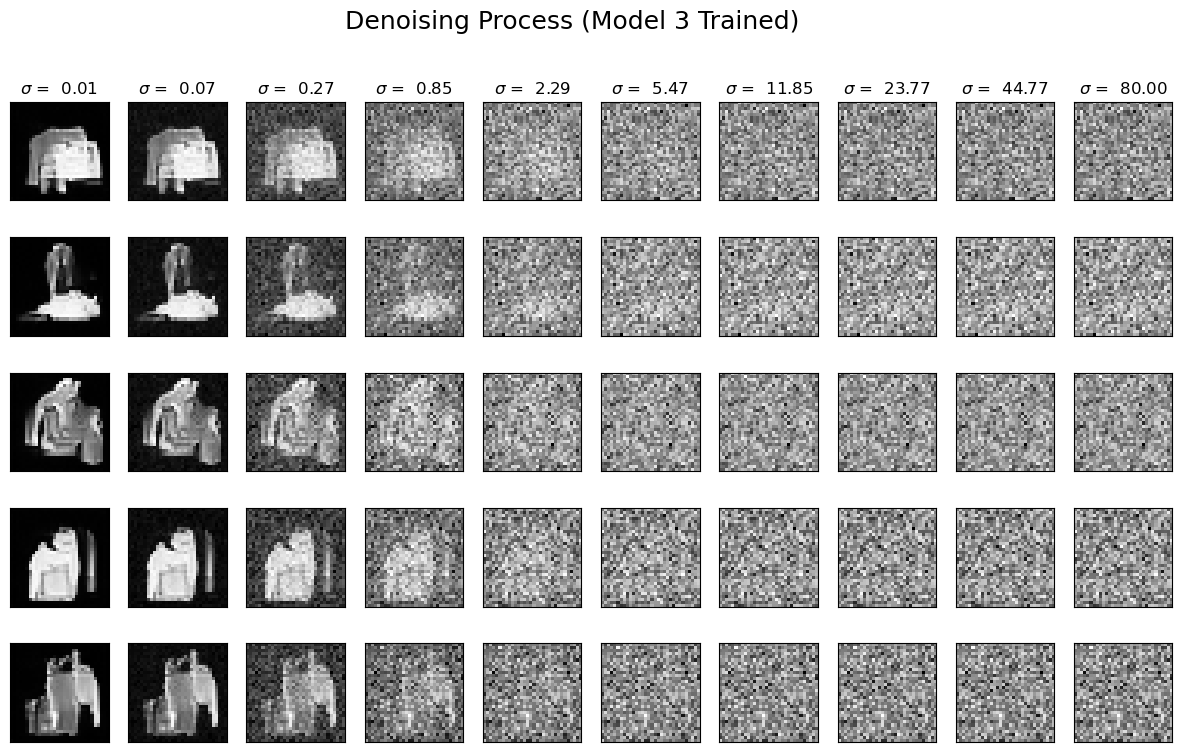

In [53]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
# plt.ylim(0, .3)

sigmas = utils.build_sigma_schedule(50).to(device)
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model3", plot_title="Denoising Process (Model 3 Trained)")

In [54]:
model = Model3(image_channels=1, nb_channels=64, num_blocks=7, cond_channels=32).to(device)

D, train_loss, val_loss = utils.train_ddpm(model, (c_in, c_out, c_skip, c_noise), N, nb_epochs=25, lr=1e-3, batch_size=32)

torch.save(model.state_dict(), f"models/model3_channels={model.conv_in.out_channels}_blocks={len(list(model.blocks.children()))}_cond={model.noise_fc1.in_features}_epochs={len(train_loss)}_lr=1e-3_bs=32")

100%|██████████| 25/25 [46:43<00:00, 112.13s/it]


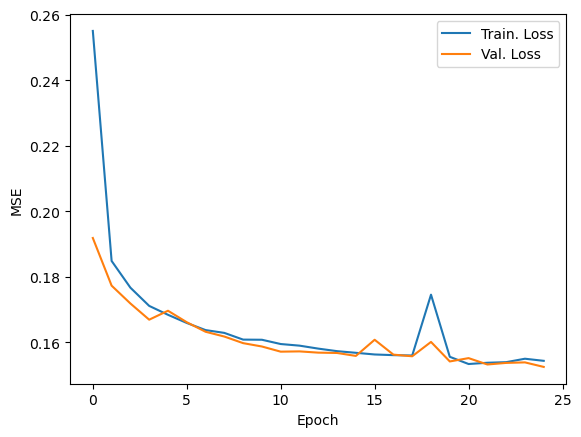

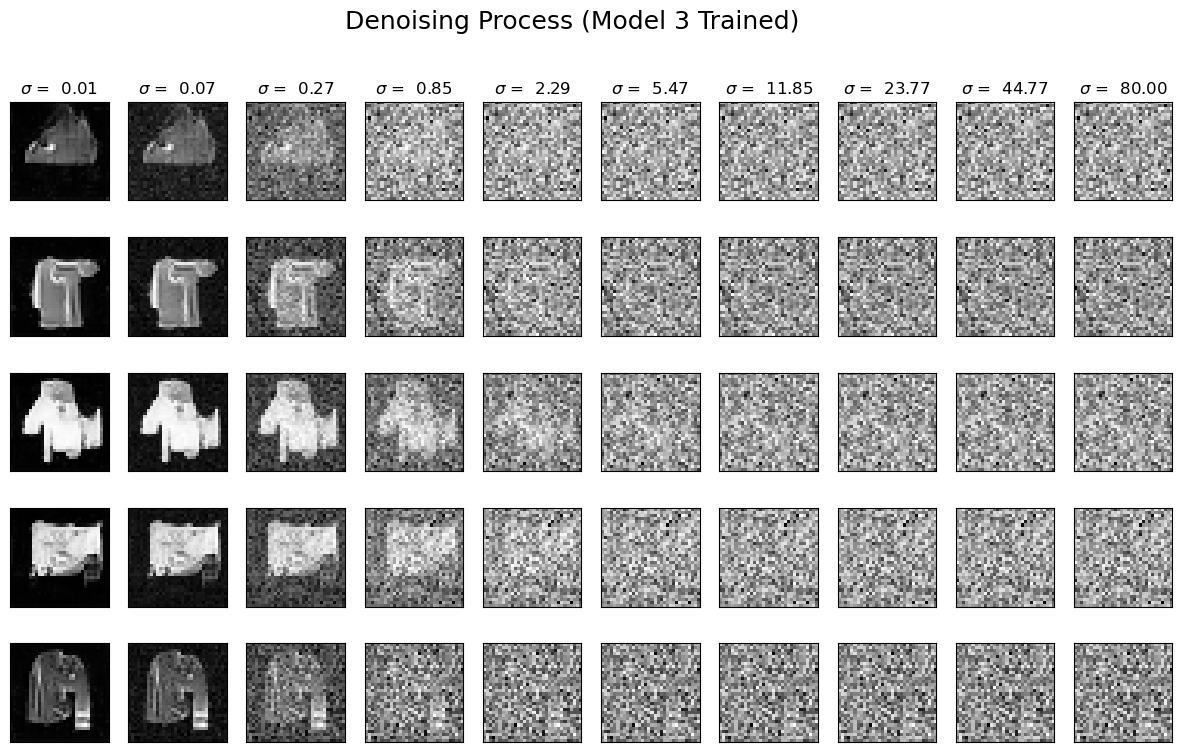

In [55]:
plt.plot(train_loss, label="Train. Loss")
plt.plot(val_loss, label="Val. Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
# plt.ylim(0, .3)

sigmas = utils.build_sigma_schedule(50).to(device)
denoised_imgs = utils.generate_images(5, imgs.shape[1:], sigmas, D, include_steps=True, device=device)
utils.plot_imgs(denoised_imgs[1::5], sigmas[::5], plot_name="denoising_process_trained_model3", plot_title="Denoising Process (Model 3 Trained)")

In [7]:
path = "models/model3_channels=64_blocks=7_cond=32_epochs=25_lr=1e-3_bs=32"

In [10]:
model = Model3(image_channels=1, nb_channels=64, num_blocks=7, cond_channels=32).to(device)
model.load_state_dict(torch.load(path))
model.eval()

D = utils.denoiser(model.forward, c_in, c_out, c_skip, c_noise)

In [11]:
n_samples = 100

dl, info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data 
    batch_size=n_samples,
    num_workers=0,   # you can use more workers if you see the GPU is waiting for the batches
    pin_memory=gpu,  # use pin memory if you're planning to move the data to GPU
)

for y, label in dl.train:
    y_data = y
    break
    
y_gen = utils.generate_images(100, imgs.shape[1:], sigmas, D, include_steps=True, device=device)[-1]

calculate_fid(y_gen, y_data.to(device))

tensor(212.4112, device='cuda:0')

In [13]:
n_samples = 100

dl, info = load_dataset_and_make_dataloaders(
    dataset_name='FashionMNIST',
    root_dir='data', # choose the directory to store the data 
    batch_size=n_samples,
    num_workers=0,   # you can use more workers if you see the GPU is waiting for the batches
    pin_memory=gpu,  # use pin memory if you're planning to move the data to GPU
)

for y, label in dl.train:
    y_data = y
    break
    
y_gen = utils.generate_images(100, imgs.shape[1:], sigmas, D, include_steps=True, device=device)[-1]

calculate_fid(y_gen, y_data.to(device))

tensor(415.2450, device='cuda:0')